In [97]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy

## 1. Data Prep

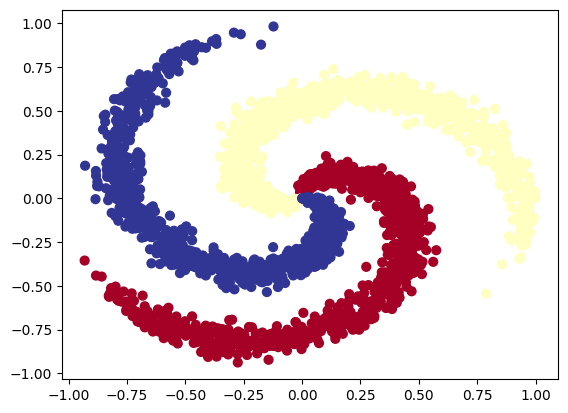

In [98]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 1000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [99]:
# Set device
device = 'mps' if torch.has_mps else 'cpu'

# Transform numpy arrays to tensors
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.long).to(device)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
# input features
in_feat = X.shape[1]

# Output features
out_feat = len(torch.unique(y))

## 2. build model

In [101]:
# Instanciate model
class MulticlassClass(nn.Module):
    # Class constructor
    def __init__(self, input, output, hidden_features=10): 
        # Inicialize parent class
        super().__init__()
        # Define model
        self.model = nn.Sequential(
            nn.Linear(in_features=input, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=output),
        ).to(device)
    # Model Forward pass
    def forward(self, x):
        return self.model(x)
    
# Inicialize model
model = MulticlassClass(
    input=in_feat,  
    output=out_feat)

# Instanciate loss FN
loss_fn = nn.CrossEntropyLoss()
# Instanciate Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

model.state_dict

<bound method Module.state_dict of MulticlassClass(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)>

In [102]:
y_train[:10]

tensor([0, 0, 0, 1, 1, 1, 0, 1, 2, 2], device='mps:0')

## 3. Train model

Epoch:    0| Trainning: Accuracy:  0.3346 loss:  1.1307| Testing: Accuracy:  0.3283 loss:  1.1290
Epoch:   10| Trainning: Accuracy:  0.3346 loss:  1.1015| Testing: Accuracy:  0.3283 loss:  1.1012
Epoch:   20| Trainning: Accuracy:  0.3346 loss:  1.0857| Testing: Accuracy:  0.3283 loss:  1.0852
Epoch:   30| Trainning: Accuracy:  0.5196 loss:  1.0727| Testing: Accuracy:  0.5267 loss:  1.0719
Epoch:   40| Trainning: Accuracy:  0.4979 loss:  1.0602| Testing: Accuracy:  0.4917 loss:  1.0595
Epoch:   50| Trainning: Accuracy:  0.6117 loss:  1.0482| Testing: Accuracy:  0.6367 loss:  1.0477
Epoch:   60| Trainning: Accuracy:  0.6208 loss:  1.0353| Testing: Accuracy:  0.6433 loss:  1.0348
Epoch:   70| Trainning: Accuracy:  0.6125 loss:  1.0211| Testing: Accuracy:  0.6367 loss:  1.0205
Epoch:   80| Trainning: Accuracy:  0.5975 loss:  1.0055| Testing: Accuracy:  0.6200 loss:  1.0048
Epoch:   90| Trainning: Accuracy:  0.5767 loss:  0.9888| Testing: Accuracy:  0.5967 loss:  0.9881
Epoch:  100| Trainni

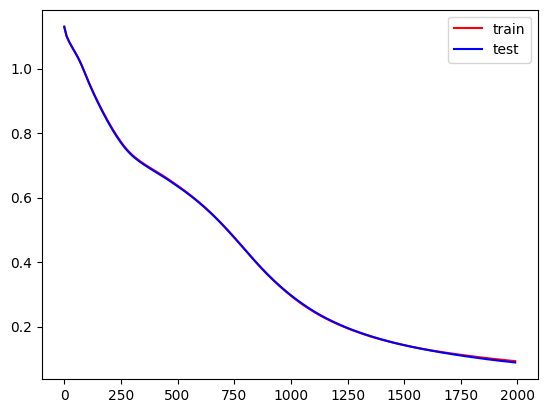

In [103]:
# Define number of epochs
epochs = 2000

# Set dictionaries to save traning metrics
epoch_values = []
train_loss_values= []
test_loss_values= []

# Instanciate loss metrics
accuracy = Accuracy(task="multiclass", num_classes=out_feat).to(device)

# Train the model
for epoch in range(epochs):
    # Model training mode
    model.train()

    # 1. Forward prop
    train_logits = model(X_train)
    y_train_pred = train_logits.softmax(dim=1).argmax(dim=1)
    # Training metrics
    loss = loss_fn(train_logits, y_train)
    train_acc = accuracy(y_train_pred, y_train)

    # 2. Backward prop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Evaluation metrics
    model.eval()

    with torch.inference_mode():
        test_logits = model(X_test)
        y_test_pred = test_logits.softmax(dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_test_pred, y_test)

        if epoch % 10 == 0:
            epoch_values.append(epoch)
            train_loss_values.append(loss.cpu().detach().numpy())
            test_loss_values.append(test_loss.cpu().detach().numpy())
            print(f"Epoch: {epoch: 4d}| Trainning: Accuracy: {train_acc: .4f} loss: {loss: .4f}| Testing: Accuracy: {test_acc: .4f} loss: {test_loss: .4f}")

plt.plot(epoch_values, train_loss_values, c='r', label='train')
plt.plot(epoch_values, test_loss_values, c='b', label='test')
plt.legend();

## 4. Evaluate model results

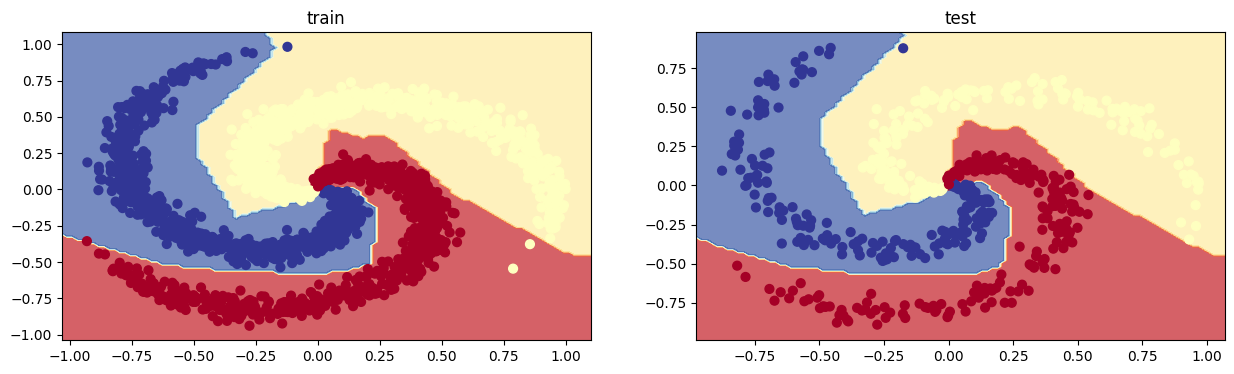

In [104]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title('train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('test')
plot_decision_boundary(model, X_test, y_test)

## 5. Make predictions

[]

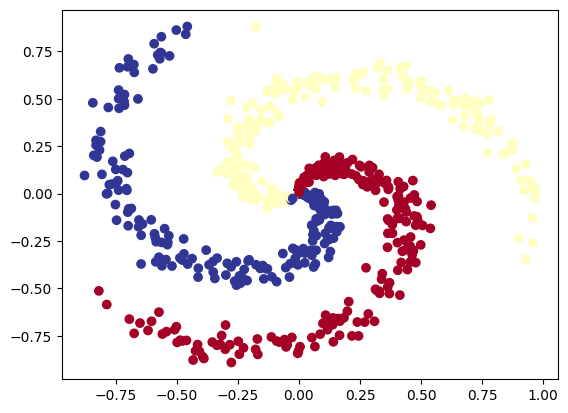

In [105]:
model.to(device)
y_pred = model(X_test).softmax(dim=1).argmax(dim=1)

plt.scatter(x=X_test.to('cpu')[:,0], y=X_test.to('cpu')[:,1], c=y_pred.to('cpu'), cmap=plt.cm.RdYlBu)
plt.plot()